In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import binned_statistic_2d

## matplotlib parameters to make my life easier
params={     
    'axes.labelsize'  : '16',   
    'axes.titlesize'  : '16',  
    'xtick.labelsize' :'16',
    'ytick.labelsize' :'16',    
    'lines.linewidth' : '2' ,   
    'legend.fontsize' : '12', 
    'figure.figsize'   : '9, 7'    
}
plt.rcParams.update(params)


In [2]:
ds_ts = xr.open_mfdataset("/scratch/xp65/dl6968/prep_hk25/prcp_ts/*.nc")

In [3]:
ds_ts

<xarray.Dataset> Size: 4MB
Dimensions:        (time: 58128)
Coordinates:
  * time           (time) datetime64[ns] 465kB 2020-03-01T00:00:33 ... 2021-0...
Data variables:
    num_obj        (time) float64 465kB dask.array<chunksize=(240,), meta=np.ndarray>
    tot_area       (time) float64 465kB dask.array<chunksize=(240,), meta=np.ndarray>
    mean_obj_area  (time) float64 465kB dask.array<chunksize=(240,), meta=np.ndarray>
    area_frac      (time) float64 465kB dask.array<chunksize=(240,), meta=np.ndarray>
    cvt_mean_prcp  (time) float64 465kB dask.array<chunksize=(240,), meta=np.ndarray>
    tot_mean_prcp  (time) float64 465kB dask.array<chunksize=(240,), meta=np.ndarray>
    cvt_tot_prcp   (time) float64 465kB dask.array<chunksize=(240,), meta=np.ndarray>

In [4]:
## array to store object number
num_obj_arr = ds_ts["num_obj"].where(np.isfinite(ds_ts["num_obj"]), other=np.nan)

## array for total area
tot_area_arr = ds_ts["tot_area"].where(np.isfinite(ds_ts["tot_area"]), other=np.nan)
## array to store mean cell size
mean_obj_area_arr = ds_ts["mean_obj_area"].where(np.isfinite(ds_ts["mean_obj_area"]), other=np.nan)
## array to store convective area fraction
area_frac_arr = ds_ts["area_frac"].where(np.isfinite(ds_ts["area_frac"]), other=np.nan)*100
## mean precipitation over convective area
cvt_mean_prcp_arr = ds_ts["cvt_mean_prcp"].where(np.isfinite(ds_ts["cvt_mean_prcp"]), other=np.nan)
## mean precipitation over the entire radar scan
tot_mean_prcp_arr = ds_ts["tot_mean_prcp"].where(np.isfinite(ds_ts["tot_mean_prcp"]), other=np.nan)
## total convective precipitation
cvt_tot_prcp_arr = ds_ts["cvt_tot_prcp"].where(np.isfinite(ds_ts["cvt_tot_prcp"]), other=np.nan)

In [5]:
ds_cape = xr.open_dataset("/scratch/xp65/dl6968/prep_hk25/environment/radar_time/cape_steiner_ts.nc")
ds_cin = xr.open_dataset("/scratch/xp65/dl6968/prep_hk25/environment/radar_time/cin_steiner_ts.nc")
ds_w500 = xr.open_dataset("/scratch/xp65/dl6968/prep_hk25/environment/radar_time/w500_steiner_ts.nc")
ds_rh500 = xr.open_dataset("/scratch/xp65/dl6968/prep_hk25/environment/radar_time/rh500_steiner_ts.nc")

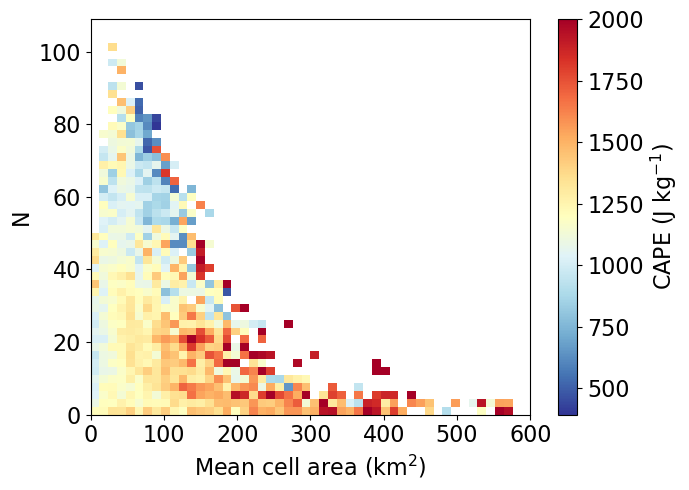

In [6]:
x = mean_obj_area_arr.values
y = num_obj_arr.values
z = ds_cape["cape"].values

xbins, ybins = 50, 50
xrange = [0,600]
yrange = [y.min(), y.max()]
## mask out nans
mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
x2, y2, z2 = x[mask], y[mask], z[mask]

stat, xedges, yedges, _ = binned_statistic_2d(
    x2,y2,z2,
    statistic='mean',
    bins=[xbins, ybins],
    range=[xrange, yrange]
)

counts, _, _, _ = binned_statistic_2d(
    x2, y2, None, statistic='count',
    bins=[xbins, ybins],
    range=[xrange, yrange]
)

## mask out bins with ≤ 1 samples
stat[counts <= 1] = np.nan
## quartiles
vals = stat.flatten()
vals = vals[~np.isnan(vals)]
q25, q50, q75 = np.percentile(vals, [25, 50, 75])

# 2) make a centre–point grid for contour (rather than edges)
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
Xc, Yc = np.meshgrid(x_centers, y_centers)

# 3) pcolormesh your mean field
fig, ax = plt.subplots(figsize=(7,5))
pcm = ax.pcolormesh(
    xedges, yedges, stat.T,
    cmap='RdYlBu_r', shading='auto',vmax=2000
)
fig.colorbar(pcm, ax=ax, label="CAPE (J kg$^{-1}$)")

# ax.clabel(cs, inline=True, fmt='%.1f', fontsize=10)

ax.set_xlabel("Mean cell area (km$^2$)")
ax.set_ylabel("N")
plt.tight_layout()


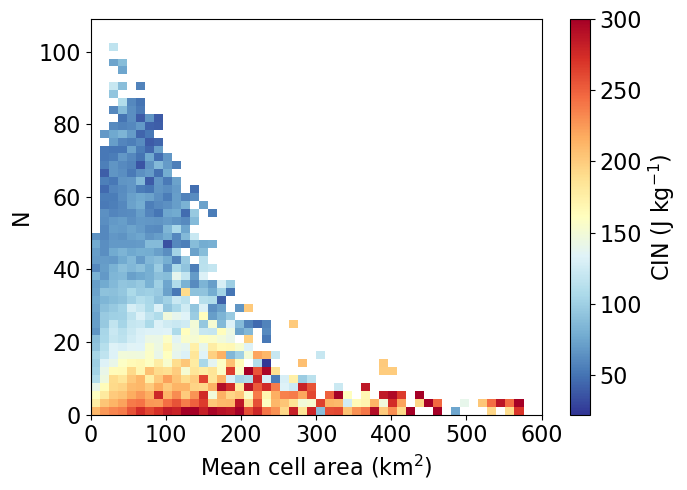

In [7]:
x = mean_obj_area_arr.values
y = num_obj_arr.values
z = ds_cin["cin"].values

xbins, ybins = 50, 50
xrange = [0,600]
yrange = [y.min(), y.max()]
## mask out nans
mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
x2, y2, z2 = x[mask], y[mask], z[mask]

stat, xedges, yedges, _ = binned_statistic_2d(
    x2,y2,z2,
    statistic='mean',
    bins=[xbins, ybins],
    range=[xrange, yrange]
)

counts, _, _, _ = binned_statistic_2d(
    x2, y2, None, statistic='count',
    bins=[xbins, ybins],
    range=[xrange, yrange]
)

## mask out bins with ≤ 1 samples
stat[counts <= 1] = np.nan

## quartiles
vals = stat.flatten()
vals = vals[~np.isnan(vals)]
q25, q50, q75 = np.percentile(vals, [25, 50, 75])

# 2) make a centre–point grid for contour (rather than edges)
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
Xc, Yc = np.meshgrid(x_centers, y_centers)

# 3) pcolormesh your mean field
fig, ax = plt.subplots(figsize=(7,5))
pcm = ax.pcolormesh(
    xedges, yedges, stat.T,
    cmap='RdYlBu_r', shading='auto',vmax=300
)
fig.colorbar(pcm, ax=ax, label="CIN (J kg$^{-1}$)")

# ax.clabel(cs, inline=True, fmt='%.1f', fontsize=10)

ax.set_xlabel("Mean cell area (km$^2$)")
ax.set_ylabel("N")
plt.tight_layout()


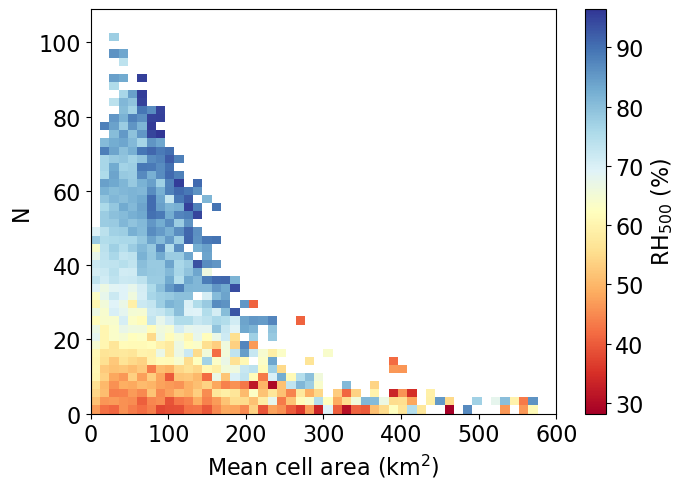

In [8]:
x = mean_obj_area_arr.values
y = num_obj_arr.values
z = ds_rh500["rh"].values

xbins, ybins = 50, 50
xrange = [0,600]
yrange = [y.min(), y.max()]
## mask out nans
mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
x2, y2, z2 = x[mask], y[mask], z[mask]

stat, xedges, yedges, _ = binned_statistic_2d(
    x2,y2,z2,
    statistic='mean',
    bins=[xbins, ybins],
    range=[xrange, yrange]
)

counts, _, _, _ = binned_statistic_2d(
    x2, y2, None, statistic='count',
    bins=[xbins, ybins],
    range=[xrange, yrange]
)

## mask out bins with ≤ 1 samples
stat[counts <= 1] = np.nan

## quartiles
vals = stat.flatten()
vals = vals[~np.isnan(vals)]
q25, q50, q75 = np.percentile(vals, [25, 50, 75])

# 2) make a centre–point grid for contour (rather than edges)
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
Xc, Yc = np.meshgrid(x_centers, y_centers)

# 3) pcolormesh your mean field
fig, ax = plt.subplots(figsize=(7,5))
pcm = ax.pcolormesh(
    xedges, yedges, stat.T,
    cmap='RdYlBu', shading='auto'
)
fig.colorbar(pcm, ax=ax, label="RH$_{500}$ (%)")

# ax.clabel(cs, inline=True, fmt='%.1f', fontsize=10)

ax.set_xlabel("Mean cell area (km$^2$)")
ax.set_ylabel("N")
plt.tight_layout()


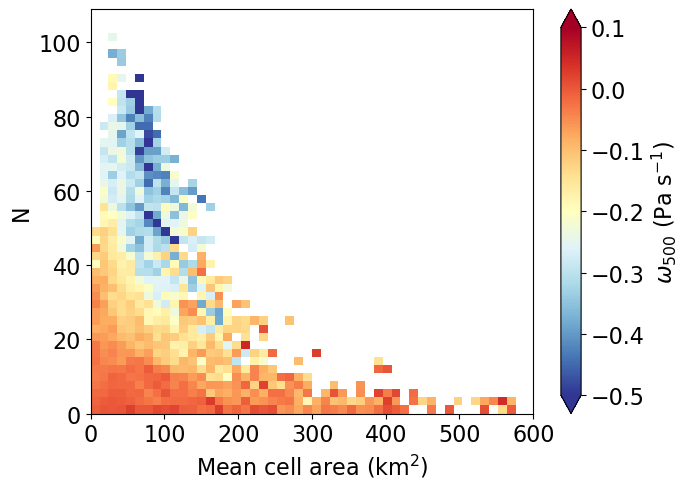

In [9]:
x = mean_obj_area_arr.values
y = num_obj_arr.values
z = ds_w500["w"].values

xbins, ybins = 50, 50
xrange = [0,600]
yrange = [y.min(), y.max()]
## mask out nans
mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
x2, y2, z2 = x[mask], y[mask], z[mask]

stat, xedges, yedges, _ = binned_statistic_2d(
    x2,y2,z2,
    statistic='mean',
    bins=[xbins, ybins],
    range=[xrange, yrange]
)

counts, _, _, _ = binned_statistic_2d(
    x2, y2, None, statistic='count',
    bins=[xbins, ybins],
    range=[xrange, yrange]
)

## mask out bins with ≤ 1 samples
stat[counts <= 1] = np.nan

## quartiles
vals = stat.flatten()
vals = vals[~np.isnan(vals)]
q25, q50, q75 = np.percentile(vals, [25, 50, 75])

# 2) make a centre–point grid for contour (rather than edges)
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
Xc, Yc = np.meshgrid(x_centers, y_centers)

# 3) pcolormesh your mean field
fig, ax = plt.subplots(figsize=(7,5))
pcm = ax.pcolormesh(
    xedges, yedges, stat.T,
    cmap='RdYlBu_r', shading='auto', vmin=-0.5, vmax=0.1
)
fig.colorbar(pcm, ax=ax, label="$\omega_{500}$ (Pa s$^{-1}$)",extend="both")

# ax.clabel(cs, inline=True, fmt='%.1f', fontsize=10)

ax.set_xlabel("Mean cell area (km$^2$)")
ax.set_ylabel("N")
plt.tight_layout()
